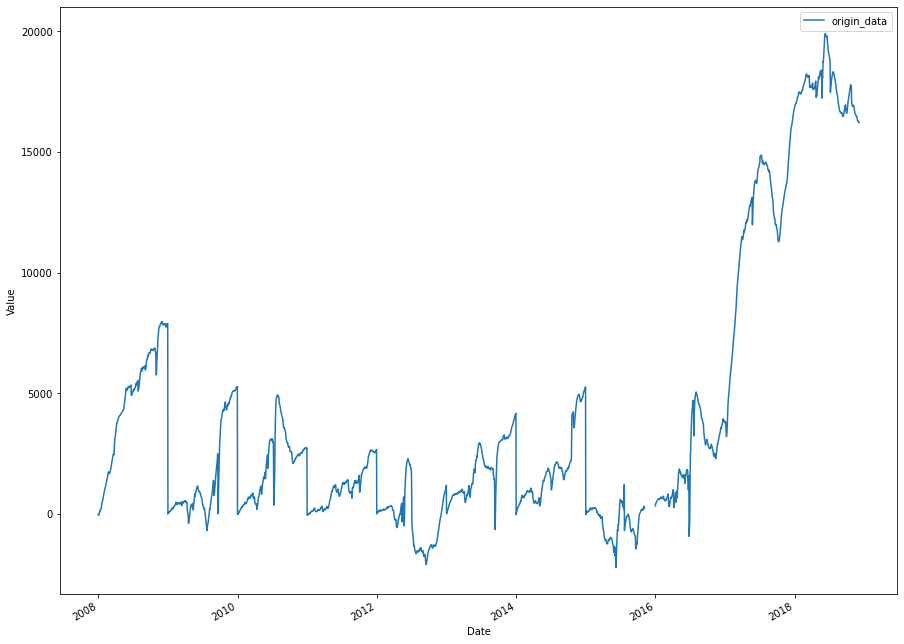

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geoist.snoopy.tsa as tsa
# parameters for loading data
data_path = Path(tsa.__file__).parent
orig_file = Path(data_path,"data",'50002_1_2312.txt')
water_file = Path(data_path,"data",'water_level_res.txt')
# parameters for processing data
na_values = None
# load data
data=pd.read_csv(Path(orig_file),parse_dates=[[0,1]],header=None,
delim_whitespace=True,index_col=[0],na_values=na_values)
data.index.name = 'time'
data.columns = ['origin_data']
ax=data.plot(figsize=(15,12),y=data.columns[0])
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.savefig("20-1.pdf")

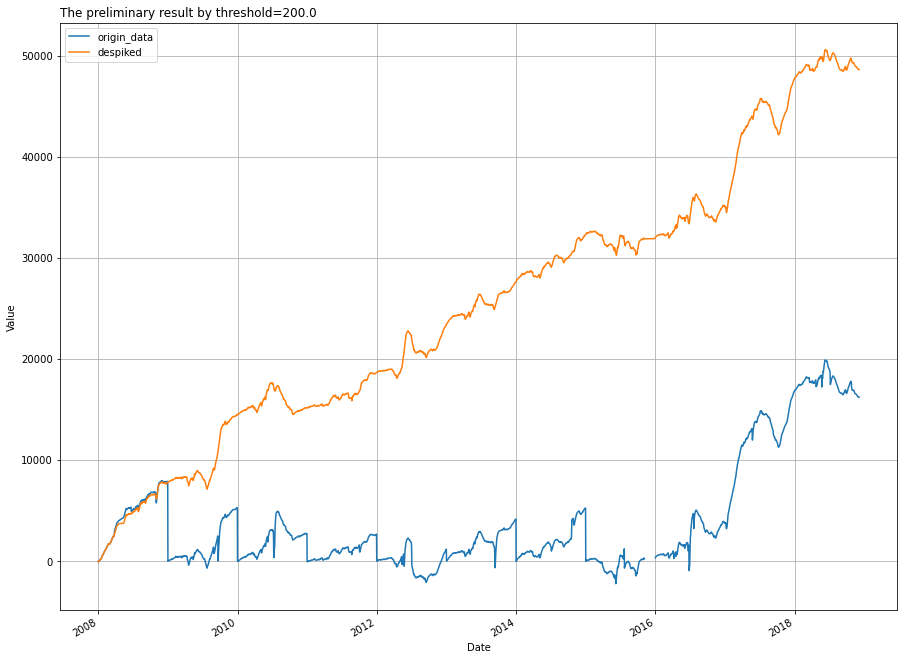

In [8]:
thresh_hold = 200.0
data['despiked'],data['flag'] = tsa.despike_v2(data['origin_data'].interpolate(),
th=thresh_hold)
ax=data.plot(figsize=(15,12),y=data.columns[:-1])
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.grid()
plt.legend()
plt.title("The preliminary result by threshold={}".format(thresh_hold),loc='left')
plt.savefig("20-2.pdf")

Augmented Dickey-Fuller test for despiked data:
  adf: -0.8225755579593959
  p-value: 0.8124005630822021
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


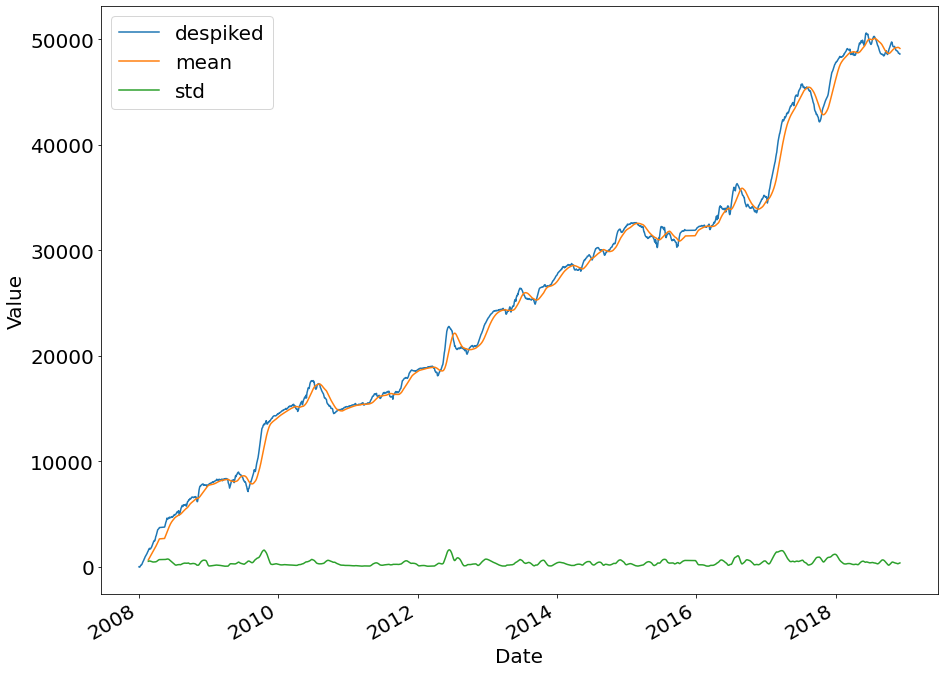

In [10]:
res = tsa.adfuller(data['despiked'].values) 
tsa.print_adf(res,'despiked data') 
window_size = 50 
data['mean'] = data['despiked'].rolling(window=window_size).mean()
data['std'] = data['despiked'].rolling(window=window_size).std() 
ax=data.plot(figsize=(15,12),y=['despiked','mean','std'],fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Value',fontsize=20)
plt.legend(fontsize=20)
plt.savefig("20-3.pdf")

In [11]:
res = tsa.adfuller(data['despiked'].values) 
tsa.print_adf(res,'despiked data')


Augmented Dickey-Fuller test for despiked data:
  adf: -0.8225755579593959
  p-value: 0.8124005630822021
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


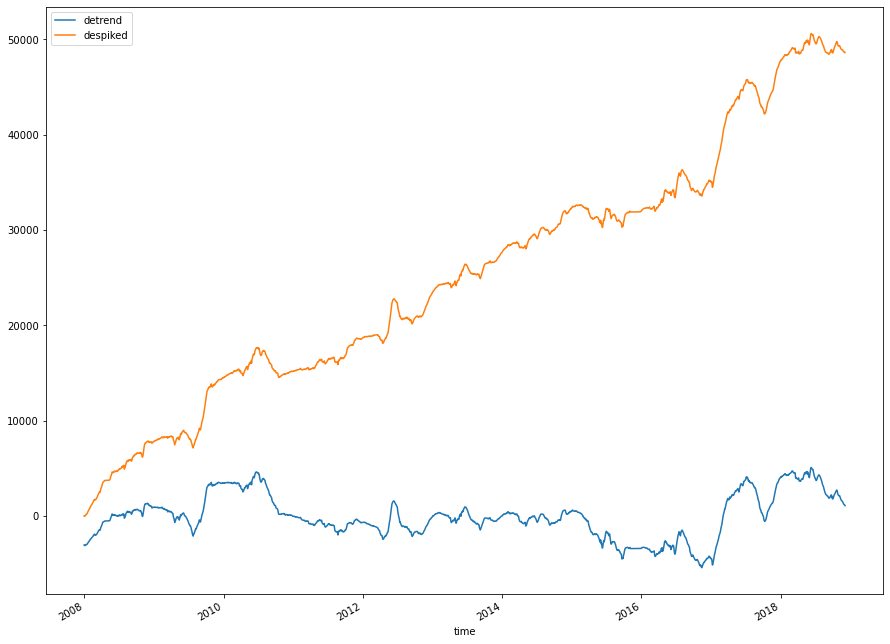

In [13]:
data['detrend'] = tsa.detrend(data['despiked']) 
data.plot(figsize=(15,12),y=['detrend','despiked'])
plt.savefig("20-4.pdf")


Augmented Dickey-Fuller test for detrended data:
  adf: -2.862697481797504
  p-value: 0.04986090928335435
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


<AxesSubplot:xlabel='time'>

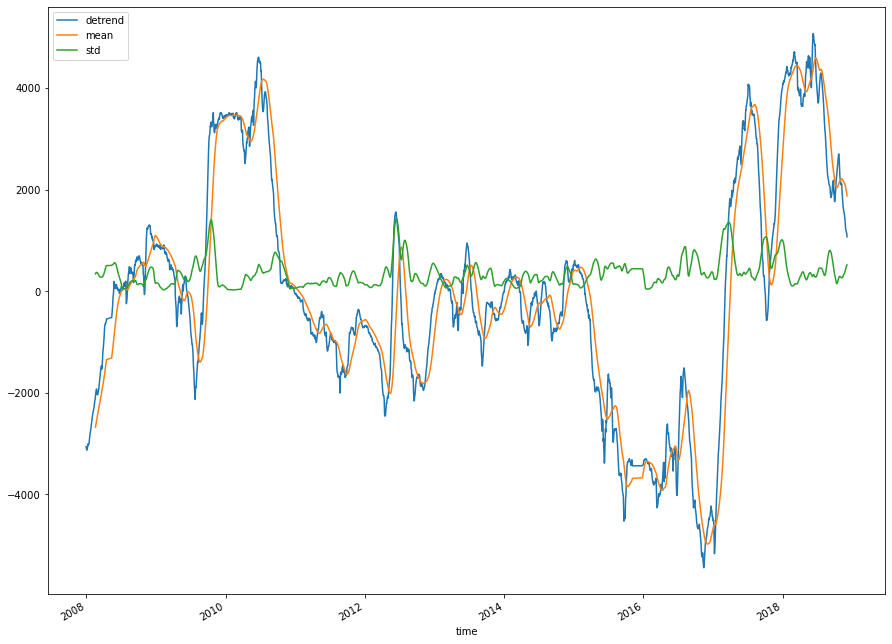

In [14]:
res = tsa.adfuller(data['detrend'].values) 
tsa.print_adf(res,'detrended data') 
data['mean'] = data['detrend'].rolling(window=window_size).mean()
data['std'] = data['detrend'].rolling(window=window_size).std() 
data.plot(figsize=(15,12),y=['detrend','mean','std'])


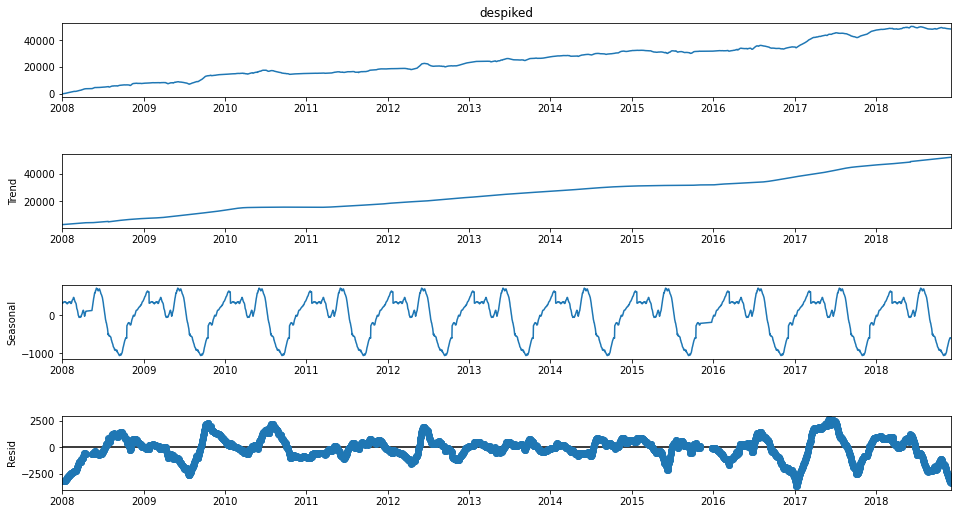

In [18]:
period = 365 
na_values_output = np.nan 
decomposition = tsa.seasonal_decompose(data['despiked'],period=period,extrapolate_trend='freq') 
fig=decomposition.plot() 
fig.set_size_inches(15,8) 
data['trend'] = decomposition.trend.fillna(na_values_output) 
data['seasonal'] = decomposition.seasonal.fillna(na_values_output) 
data['residual'] = decomposition.resid.fillna(na_values_output)
plt.savefig("20-5.pdf")


Augmented Dickey-Fuller test for residual data:
  adf: -5.196623657704803
  p-value: 8.932706805879723e-06
  norder: 13
  number of points: 3901
  critical values:
    1% : -3.432027418154056
    5% : -2.8622811914877873
    10% : -2.567164545006864


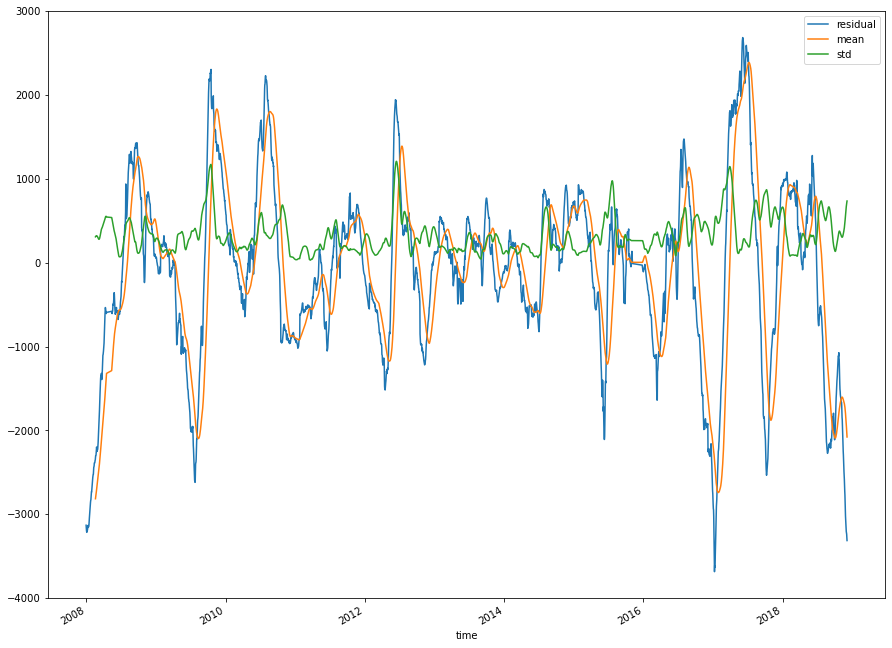

In [20]:
# test stationary on residual 
res = tsa.adfuller(data['residual'].dropna().values) 
tsa.print_adf(res,'residual data') 
window_size=50
data['mean'] = data['residual'].rolling(window=window_size).mean() 
data['std'] = data['residual'].rolling(window=window_size).std() 
data.plot(figsize=(15,12),y=['residual','mean','std'])
plt.savefig("20-6.pdf")

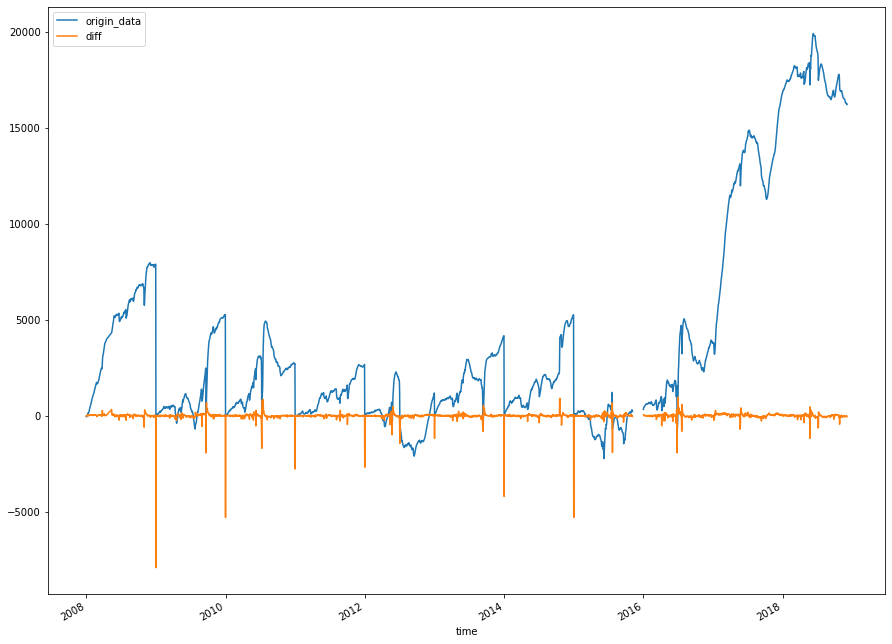

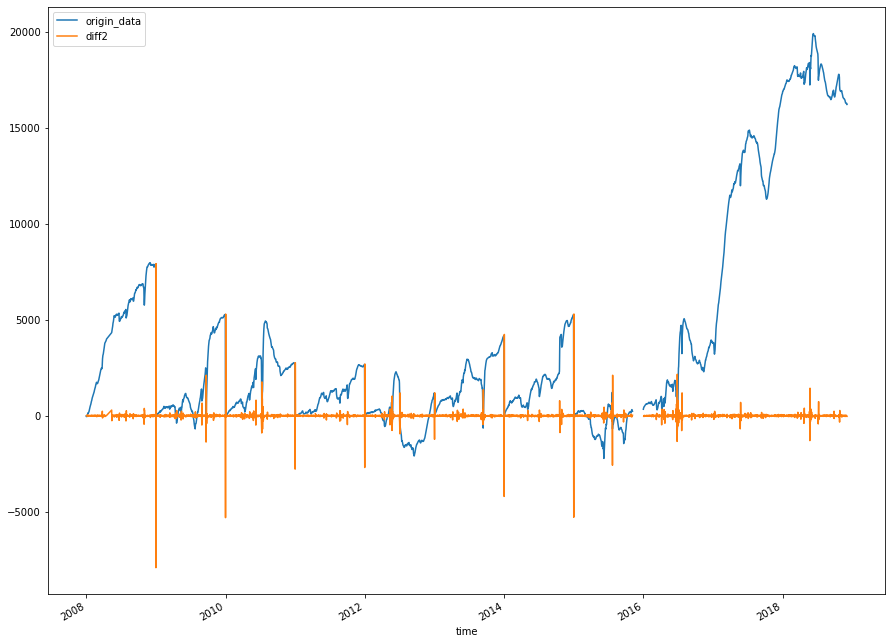

In [21]:
# first order difference 
data['diff'] = data['origin_data'].diff() 
ax = data.plot(figsize=(15,12),y=['origin_data','diff']) 
# second order difference 
data['diff2'] = data['diff'].diff() 
ax = data.plot(figsize=(15,12),y=['origin_data','diff2'])


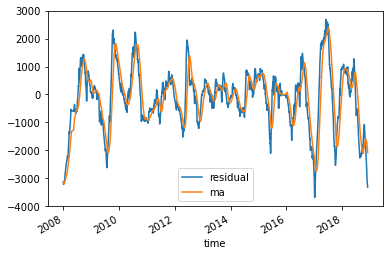

In [23]:
# moving average 
window_size = 50 
center = False 
data['ma'] = data['residual'].rolling(window=window_size,center=center,min_periods=1).mean() 
data.plot(y=['residual','ma'])
plt.savefig("20-7.pdf")

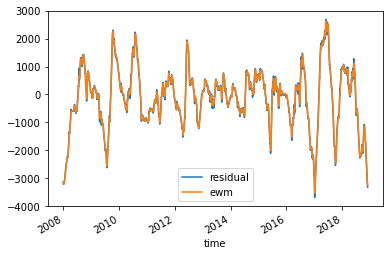

In [25]:
# exponential moving average
factor = 0.3 
data['ewm'] = data['residual'].ewm(alpha=factor).mean() 
data.plot(y=['residual','ewm'])
plt.savefig("20-8.pdf")


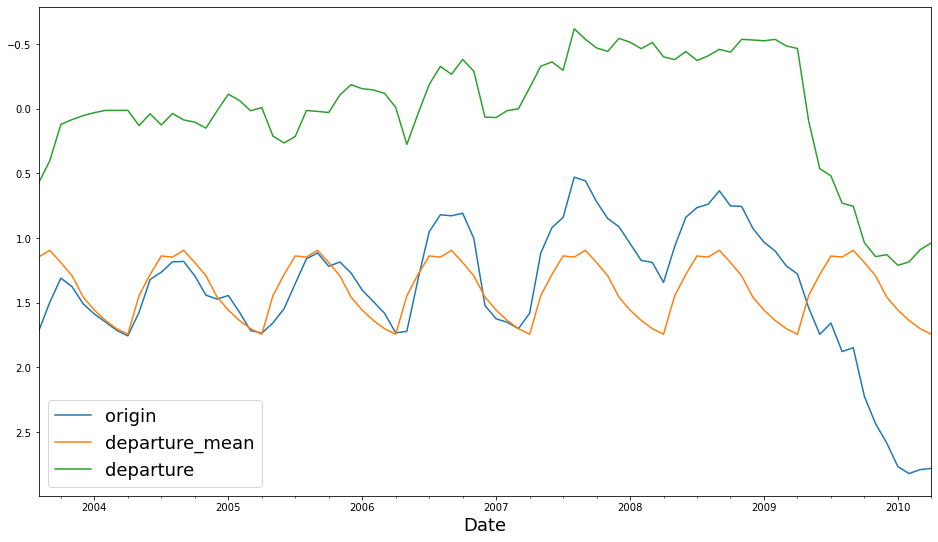

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geoist.snoopy.tsa as tsa
data_path = Path(tsa.__file__).parent
water_file = Path(data_path,"data",'water_level_res.txt')

dateparser = lambda x: pd.to_datetime(x,format='%Y%m') 
water = pd.read_csv(water_file,header=None,parse_dates=True, 
index_col=0,delim_whitespace=True,date_parser=dateparser) 
water[water == 99999] = np.nan 
water = water.interpolate() 
water.columns = ['origin','mean','departure'] 
water_origin = pd.DataFrame(water[water.columns[0]]).copy()
# call departure, and plot. 
water_origin,_ = tsa.despike_v2(water_origin,th=200) 
wate_departure = tsa.departure(water_origin) 
ax = wate_departure.plot(figsize=(16,9)) 
ax.invert_yaxis()
ax.set_xlabel('Date',fontsize=18)
plt.legend(fontsize=18)
plt.savefig("20-9.pdf")

In [28]:
# upsample 
water_daily = water_origin.resample('D').asfreq().interpolate() 
water_daily.head(10) 
# downsample 
water_monthly = water_daily.resample('MS').asfreq().interpolate() 
water_monthly.head(10) 
# monthly mean 
water_monthly = water_daily.resample('MS').mean().interpolate() 
water_monthly.head(10) 


,origin,departure_mean,departure
0,,,
2003-08-01,1.612913,1.121462,0.491451
2003-09-01,1.406578,1.139907,0.266672
2003-10-01,1.341535,1.238634,0.102902
2003-11-01,1.439835,1.371030,0.068805
2003-12-01,1.546387,1.504623,0.041765
2004-01-01,1.617042,1.595389,0.021653
2004-02-01,1.680003,1.667430,0.012574
2004-03-01,1.733706,1.721296,0.012410
2004-04-01,1.668272,1.599229,0.069043


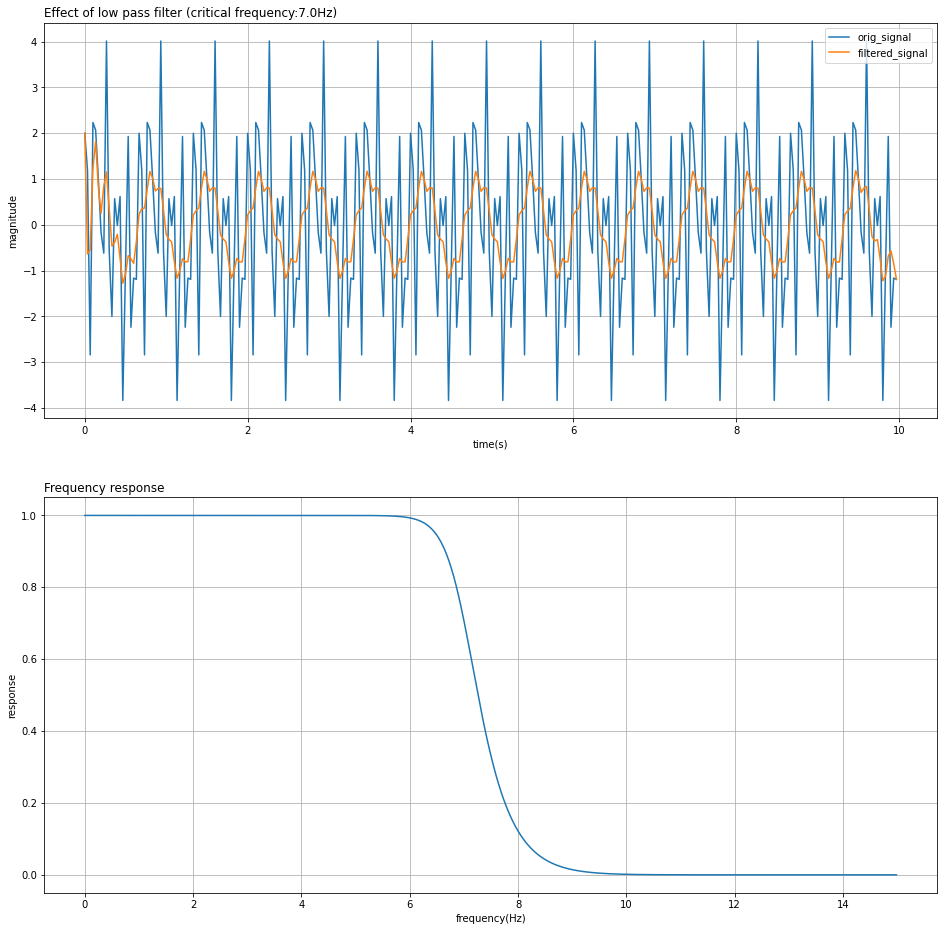

In [30]:
# filter
# generate dataset 
sample_rate = 30.0 
n = np.arange(300) 
orig_data = np.sin(0.1*np.pi*n)+2.0*np.cos(0.5*np.pi*n)+1.5*np.sin(0.8*np.pi*n) 
# generate filter 
order = 10 
nyq = 0.5*sample_rate 
lower_cut_rate = 7.0 / nyq 
upper_cut_rate = 10.0 / nyq 
sos = tsa.butter(10,lower_cut_rate,btype='low',output='sos') 
# apply filter to data 
filtered_data = tsa.sosfiltfilt(sos,orig_data) 
# plot data 
fig = plt.figure(figsize=(16,16)) 
ax = plt.subplot(211) 
ax.plot(n/sample_rate,orig_data,label='orig_signal') 
ax.plot(n/sample_rate,filtered_data,label='filtered_signal') 
ax.set_xlabel('time(s)') 
ax.set_ylabel('magnitude') 
ax.legend() 
plt.title('Effect of low pass filter (critical frequency:{}Hz)'.format(lower_cut_rate*nyq),loc='left') 
plt.grid() 
ax = plt.subplot(212) 
w,h = tsa.sosfreqz(sos,worN=1000) 
ax.plot(0.5*sample_rate*w/np.pi,np.abs(h)) 
ax.set_xlabel('frequency(Hz)') 
ax.set_ylabel('response') 
plt.title('Frequency response',loc='left') 
plt.grid()
plt.savefig("20-10.pdf")

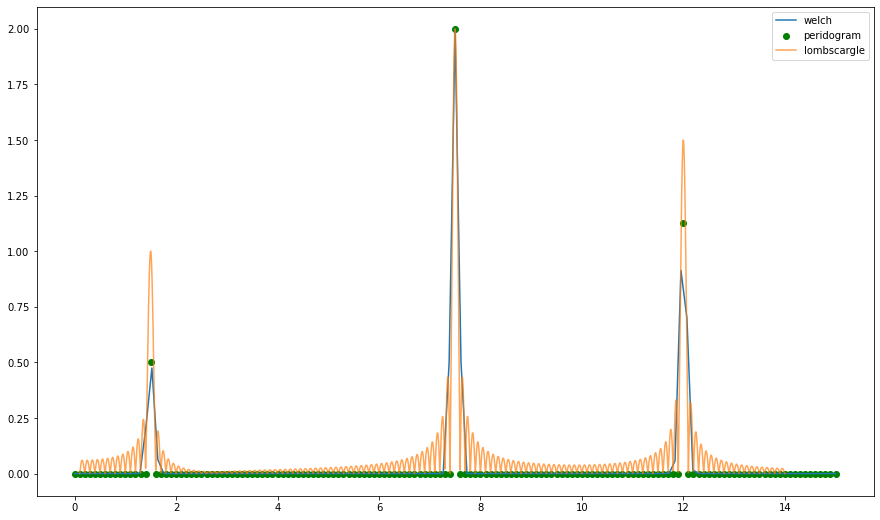

In [32]:
# psd 
import numpy as np
import matplotlib.pyplot as plt
import geoist.snoopy.tsa as tsa
sample_rate = 30.0 
n = np.arange(300) 
orig_data = np.sin(0.1*np.pi*n)+2.0*np.cos(0.5*np.pi*n)+1.5*np.sin(0.8*np.pi*n) 

f_w,pxx_w = tsa.welch(orig_data,sample_rate,nperseg=256,scaling='spectrum') 
f_p,pxx_p = tsa.periodogram(orig_data,sample_rate,scaling='spectrum') 
f_l = np.linspace(0.1,14,3000)*np.pi*2.0 
pxx_l = tsa.lombscargle(n/sample_rate,orig_data,f_l) 
# plot result 
fig = plt.figure(figsize=(15,9)) 
ax = fig.add_subplot(111)
ax.plot(f_w,pxx_w,label='welch') 
ax.scatter(f_p,pxx_p,label='peridogram',c='g') 
ax.plot(0.5*f_l/np.pi,np.sqrt(pxx_l*4.0/len(orig_data)),alpha=0.7,label='lombscargle') 
ax.legend()
plt.savefig("20-11.pdf")

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  w

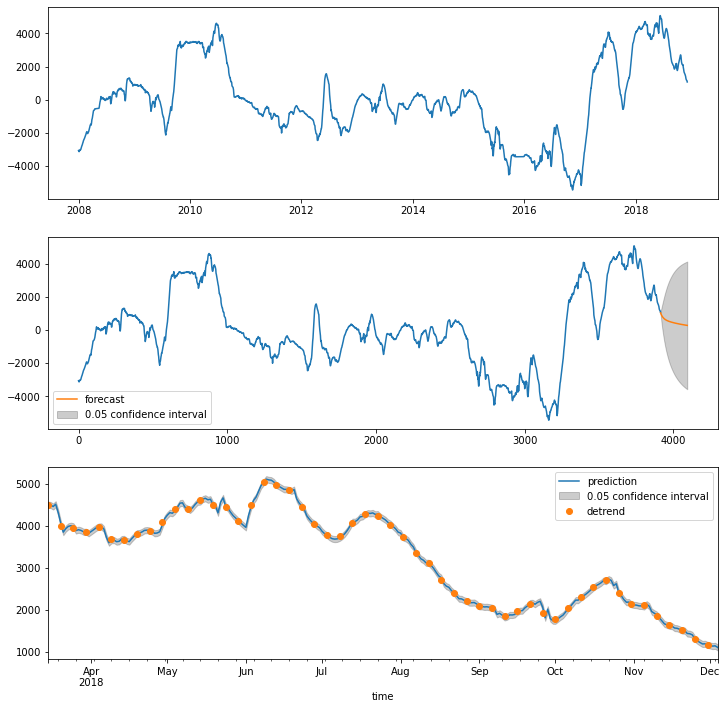

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geoist.snoopy.tsa as tsa
# parameters for loading data
data_path = Path(tsa.__file__).parent
orig_file = Path(data_path,"data",'50002_1_2312.txt')
# parameters for processing data
na_values = None
# load data
data=pd.read_csv(Path(orig_file),parse_dates=[[0,1]],header=None,
delim_whitespace=True,index_col=[0],na_values=na_values)
data.index.name = 'time'
data.columns = ['origin_data']
thresh_hold = 200.0
data['despiked'],data['flag'] = tsa.despike_v2(data['origin_data'].interpolate(),
th=thresh_hold)
data['detrend'] = tsa.detrend(data['despiked'])

# ARIMA 
p = 5 
d = 0 
q = 1 
P, D, Q , s= 0, 0, 0, 0 
model = tsa.SARIMAX(data['detrend'].dropna(), 
order=(p,d,q), 
seasonal_order=(P,D,Q,s), 
enforce_stationarity=False) 
rests = model.fit() 
pred = rests.get_forecast(180) 
pci = pred.conf_int() 
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1,figsize=(12,12)) 
ax0.plot(data['detrend'].dropna()) 
ax1.plot(data['detrend'].dropna().values) 
pred.predicted_mean.plot(ax=ax1,label='forecast') 
ax1.fill_between(pci.index,pci.iloc[:,0],pci.iloc[:,1],color='k',
alpha=0.2,label='0.05 confidence interval') 
ax1.legend() 
start_day=365*10 
pred = rests.get_prediction(start_day) 
pci = pred.conf_int() 
pred.predicted_mean.plot(ax=ax2,label='prediction') 
ax2.fill_between(pci.index,pci.iloc[:,0],pci.iloc[:,1],color='k',alpha=0.2, 
label='0.05 confidence interval') 
data['detrend'].dropna().iloc[start_day:].asfreq('5d').plot(style='o',ax=ax2) 
ax2.legend()
plt.savefig("20-12.pdf")

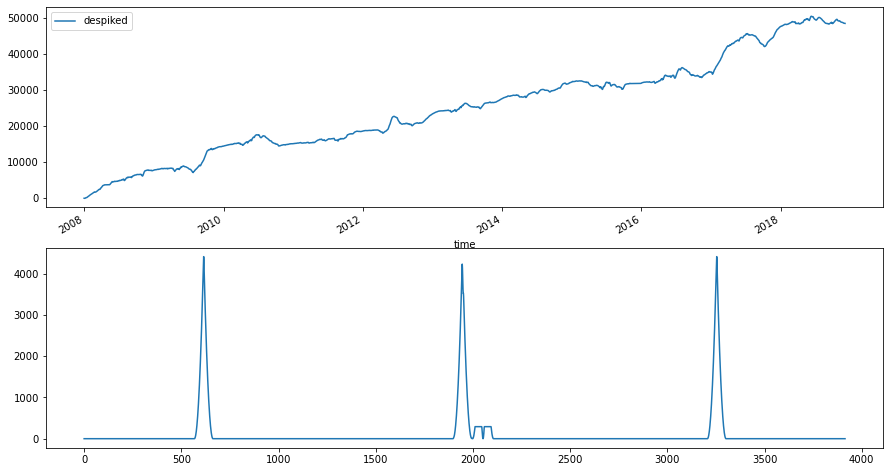

In [37]:
from geoist.snoopy.anomaly_detector import AnomalyDetector 
ts = dict(zip(range(len(data)),data['despiked'].values)) 
my_detector = AnomalyDetector(ts) 
score = my_detector.get_all_scores() 
fig = plt.figure(figsize=(15,9)) 
ax = fig.add_subplot(211) 
data.plot(ax=ax,y=['despiked']) 
ax = fig.add_subplot(212) 
ax.plot(score.timestamps,score.values)
ts = dict(zip(range(len(data)),data['despiked'].values))
plt.savefig("20-13.pdf")

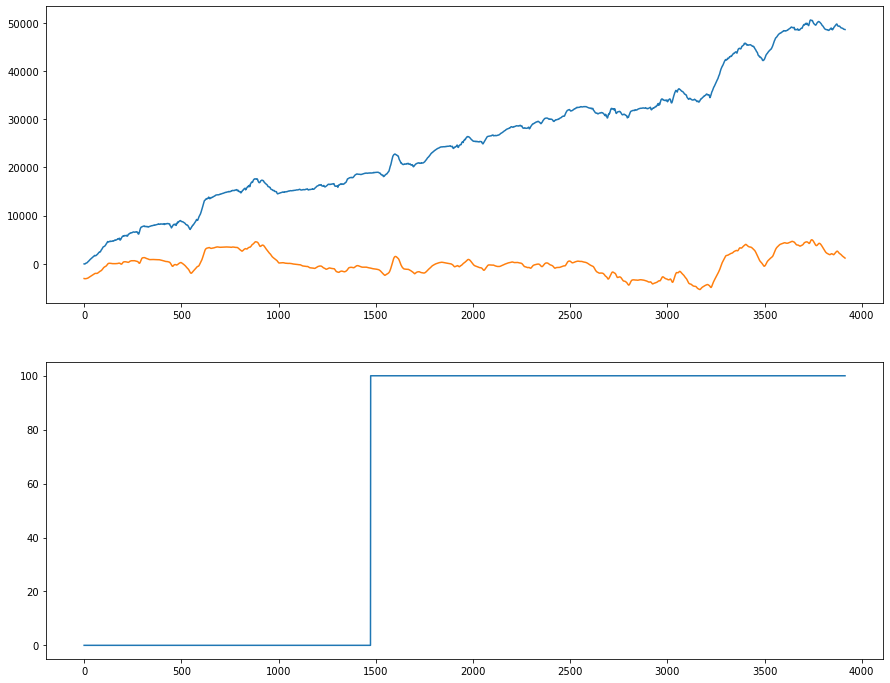

In [39]:
from geoist.snoopy.anomaly_detector import AnomalyDetector 
ts = dict(zip(range(len(data)),data['despiked'].values)) 
window_size = 10 
center = False 
data['ma'] = data['detrend'].rolling(window=window_size,center=center,min_periods=1).mean() 
tsb = dict(zip(range(len(data)),data['ma'].values)) 
# anomaly baseline 
algorithm_params = {'percent_threshold_upper': 20, 
'offset': 20000, 
'scan_window': 24, 
'confidence': 0.01} 
my_detector = AnomalyDetector(ts, baseline_time_series = tsb, algorithm_name = 'sign_test', 
algorithm_params = algorithm_params) 
score = my_detector.get_all_scores() 
fig = plt.figure(figsize=(15,12)) 
ax = fig.add_subplot(211) 
ax.plot(data['despiked'].dropna().values) 
ax.plot(data['ma'].dropna().values) 
ax = fig.add_subplot(212) 
ax.plot(score.timestamps,score.values)
plt.savefig("20-16.pdf")